#  Business Understanding

##  Project Overview

This project aims to build a predictive model that determines whether a client will subscribe to a **bank term deposit**, based on data collected from direct marketing campaigns conducted via phone calls. The goal is to empower the bank’s marketing team with insights and tools to better target potential subscribers, improve campaign efficiency, and reduce operational costs.

---

##  Business Problem

The bank is investing in direct marketing campaigns, but not all efforts lead to successful conversions. By identifying the characteristics and behaviors of clients who are most likely to subscribe, the bank can focus its resources on high-probability leads — ultimately improving the **Return on Marketing Investment (ROMI)**.

---

##  Project Goals

- **Predict Client Behavior**: Build a machine learning model to predict whether a client will say *“yes”* or *“no”* to subscribing to a term deposit.
- **Discover Key Drivers**: Identify and interpret the factors that significantly influence a client's decision to subscribe.
- **Support Decision-Making**: Provide actionable recommendations that the marketing team can use to optimize targeting strategies and resource allocation.

---

##  Success Criteria

- A classification model with strong performance, measured by:
  - Accuracy
  - Precision
  - Recall
  - F1-Score
- A well-documented and reproducible end-to-end analysis using version control.
- Business insights that are interpretable and actionable by stakeholders.

---

##  Key Business Questions

1. What are the most influential factors that determine whether a client subscribes?
2. Are certain client demographics (age, job, education) more likely to subscribe?
3. Does the timing or duration of the last contact influence subscription rates?
4. Are previous interactions with the bank predictive of subscription?
5. Can we identify client segments with higher subscription potential?

---

##  Hypothesis Statement

**H₀ (Null Hypothesis):** Duration of the last contact has **no significant effect** on a client’s likelihood to subscribe to a term deposit.  
**H₁ (Alternative Hypothesis):** Duration of the last contact **significantly affects** a client’s likelihood to subscribe.

 This hypothesis will be tested using statistical and visual analysis during the EDA phase.


## Importations

In [63]:
#  Core Libraries
import numpy as np
import pandas as pd
import sys
import os
import xgboost as xgb

# Add project root to the Python path so it can find `src`
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

#  Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#  Data Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

#  Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from src.data_prep import main as prep_main
from scipy.stats import randint, uniform


#  Evaluation
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

#  Imbalanced Data Handling
from imblearn.over_sampling import SMOTE

#  Model Persistence
import joblib

#  General Utilities
import warnings
warnings.filterwarnings("ignore")

#  Statistical Testing & Model Interpretability (Optional but added for completeness)
import statsmodels.api as sm  # For hypothesis testing/logistic regression summary
import shap  # SHAP values for model explainability
import eli5  # Feature importance explanations (works well with sklearn)


#  Data Understanding

## Load Dataset

In [5]:
# Load dataset
df = pd.read_csv('../data/raw/bank-additional-full.csv', sep=';') 

In [7]:
# Preview the data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
# Check dimensions
print("Shape:", df.shape)

Shape: (41188, 21)


In [9]:
# Check data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Summary Statistics

In [10]:
# Numerical summary
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [11]:
# Categorical summary
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


### Checking for Missing Values

In [13]:
# Total missing values per column
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Check for Duplicates

In [15]:
# Check duplicate rows count
duplicates_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")


Number of duplicate rows: 12


In [ ]:
# Remove duplicates
df = df.drop_duplicates()

In [17]:
#  Balance check
print(df['y'].value_counts())

y
no     36537
yes     4639
Name: count, dtype: int64


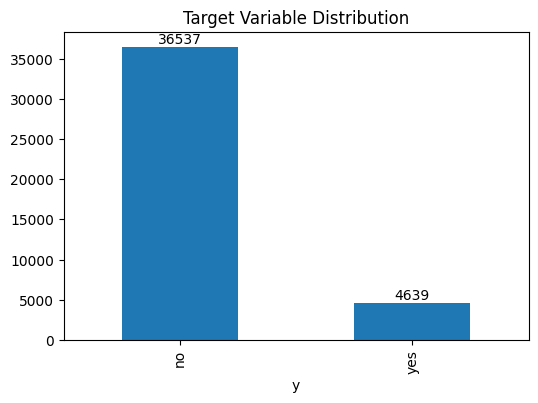

In [19]:
ax = df['y'].value_counts().plot(kind='bar', title='Target Variable Distribution', figsize=(6,4))
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom')

plt.show()

In [20]:
print(df[['duration', 'campaign']].describe())

           duration      campaign
count  41176.000000  41176.000000
mean     258.315815      2.567879
std      259.305321      2.770318
min        0.000000      1.000000
25%      102.000000      1.000000
50%      180.000000      2.000000
75%      319.000000      3.000000
max     4918.000000     56.000000


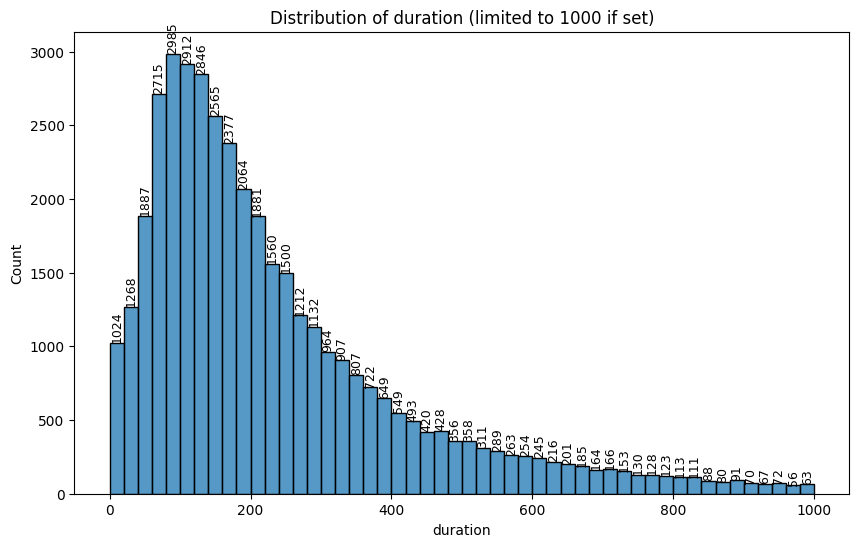

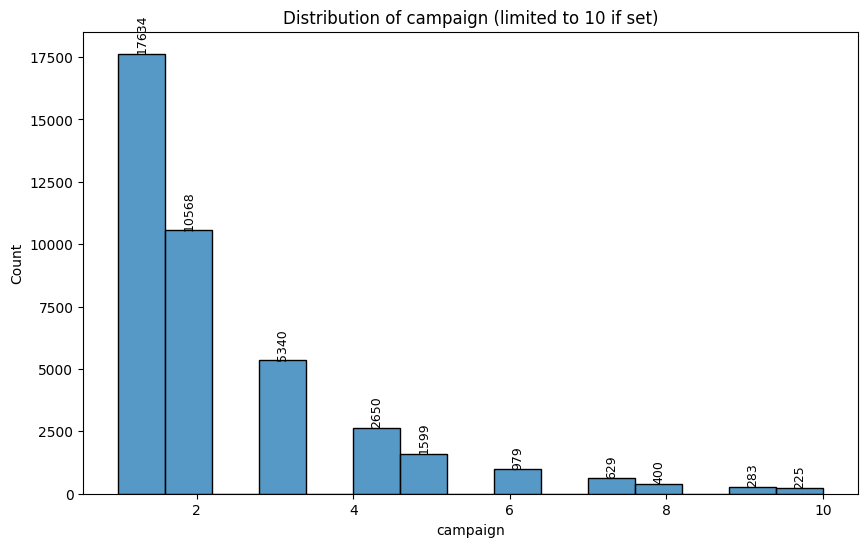

In [21]:
def plot_hist_with_counts(df, column, bins=30, limit=None):
    data = df[column]
    if limit:
        data = data[data <= limit]
    
    plt.figure(figsize=(10,6))
    ax = sns.histplot(data, bins=bins, kde=False)
    
    # Add count labels on bars
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, rotation=90)
    
    plt.title(f'Distribution of {column} (limited to {limit} if set)')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# Plot duration (limit to 1000 for better view)
plot_hist_with_counts(df, 'duration', bins=50, limit=1000)

# Plot campaign (limit to 10)
plot_hist_with_counts(df, 'campaign', bins=15, limit=10)

#### The above shows:

A right-skewed distribution for both variables.

Most customers were contacted for a short duration and few times (low campaign count).

#### Dive into pdays

In [22]:
df['pdays'].describe()

count    41176.000000
mean       962.464810
std        186.937102
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: pdays, dtype: float64

In [23]:
df['pdays'].value_counts().sort_index()

pdays
0         15
1         26
2         61
3        439
4        118
5         46
6        412
7         60
8         18
9         64
10        52
11        28
12        58
13        36
14        20
15        24
16        11
17         8
18         7
19         3
20         1
21         2
22         3
25         1
26         1
27         1
999    39661
Name: count, dtype: int64

####  Interpretation:
Value 999 appears 39,661 times, which is 96.3% of the dataset. This represents clients not previously contacted.

All other values (0–27) are actual numbers of days since the client was last contacted in a previous campaign.

### New Binary Feature

In [24]:
df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)


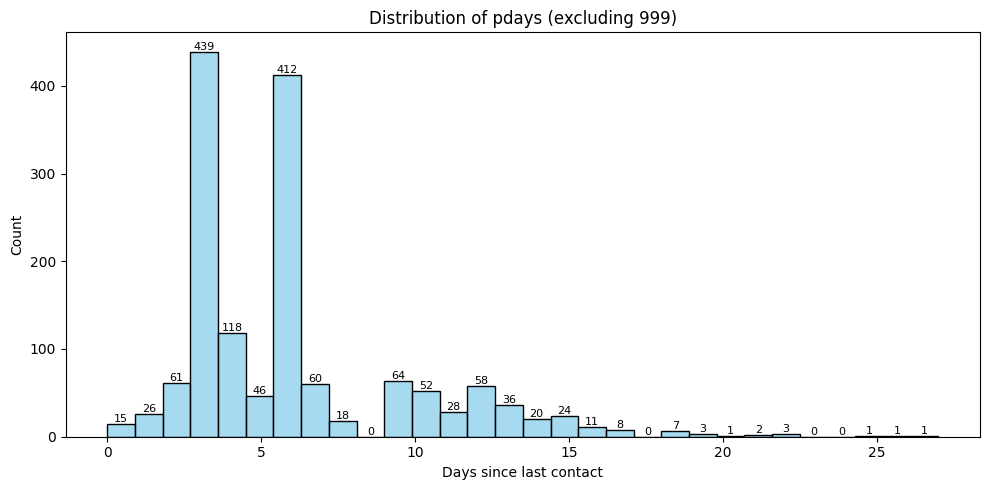

In [25]:
# Filter out 999 values
pdays_valid = df[df['pdays'] != 999]['pdays']

plt.figure(figsize=(10, 5))
sns.histplot(pdays_valid, bins=30, kde=False, color='skyblue')
plt.title('Distribution of pdays (excluding 999)')
plt.xlabel('Days since last contact')
plt.ylabel('Count')

# Annotate bars
counts, bin_edges = np.histogram(pdays_valid, bins=30)
for i in range(len(counts)):
    plt.text((bin_edges[i] + bin_edges[i+1]) / 2, counts[i], str(counts[i]), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

#### Visualize binary feature

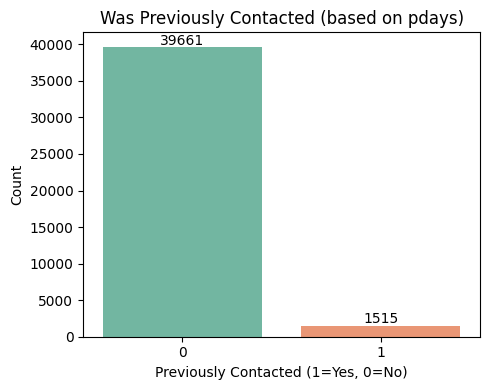

In [26]:

plt.figure(figsize=(5, 4))
sns.countplot(x='was_previously_contacted', data=df, palette='Set2')

for i, count in enumerate(df['was_previously_contacted'].value_counts().sort_index()):
    plt.text(i, count + 300, str(count), ha='center')

plt.title('Was Previously Contacted (based on pdays)')
plt.xlabel('Previously Contacted (1=Yes, 0=No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

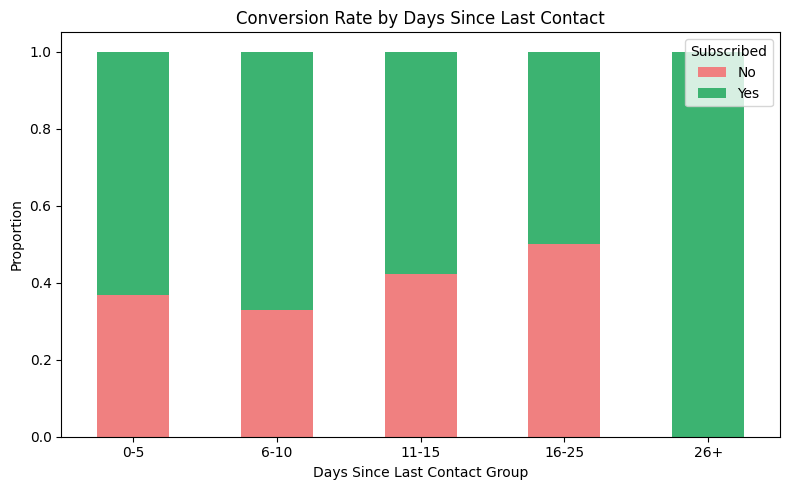

In [27]:
# Filter out 999 and group
contacted = df[df['pdays'] != 999]
contacted['pdays_group'] = pd.cut(contacted['pdays'], bins=[-1, 5, 10, 15, 25, 999], 
                                  labels=['0-5', '6-10', '11-15', '16-25', '26+'])

# Plot conversion rate by pdays group
conversion_rates = contacted.groupby('pdays_group')['y'].value_counts(normalize=True).unstack().fillna(0)

conversion_rates.plot(kind='bar', stacked=True, color=['lightcoral', 'mediumseagreen'], figsize=(8,5))
plt.title('Conversion Rate by Days Since Last Contact')
plt.xlabel('Days Since Last Contact Group')
plt.ylabel('Proportion')
plt.legend(title='Subscribed', labels=['No', 'Yes'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Final Takeaways on pdays:
999 = client wasn't contacted before.

Only ~3.7% (1,515 out of 41,176) were previously contacted (pdays ≠ 999).

Most prior contacts occurred 5–6 days before the current campaign.

Knowing whether a client was previously contacted (and when) can help segment the audience, but this variable has limited variance due to the dominance of 999.

### Dive into Duration

In [28]:
print(df['duration'].describe())


count    41176.000000
mean       258.315815
std        259.305321
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64


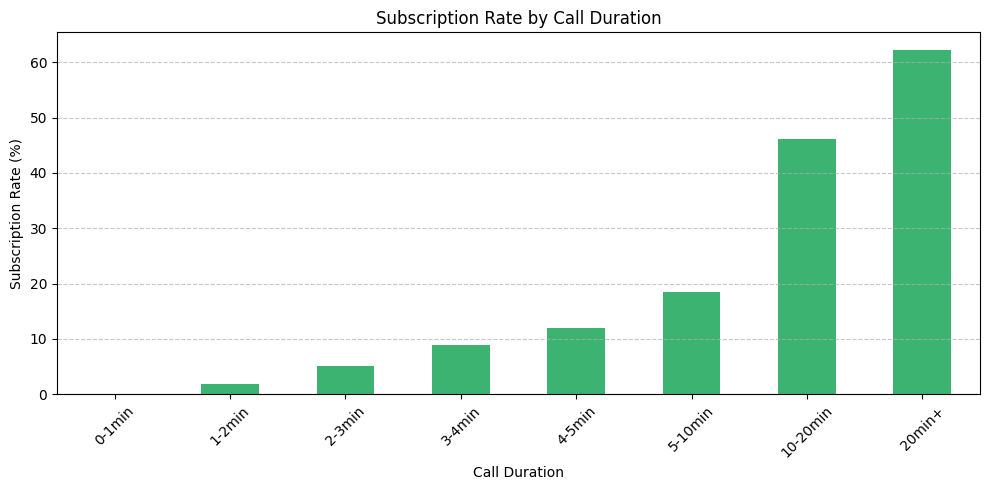

In [29]:
# Create bins for duration
bins = [0, 60, 120, 180, 240, 300, 600, 1200, 5000]
labels = ['0-1min', '1-2min', '2-3min', '3-4min', '4-5min', '5-10min', '10-20min', '20min+']
df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)

# Group by duration bins and calculate subscription rate
bin_summary = df.groupby('duration_bin')['y'].value_counts(normalize=True).unstack().fillna(0)
bin_summary['subscription_rate'] = bin_summary['yes'] * 100  # percentage

# Plot
bin_summary['subscription_rate'].plot(kind='bar', color='mediumseagreen', figsize=(10,5))
plt.title("Subscription Rate by Call Duration")
plt.ylabel("Subscription Rate (%)")
plt.xlabel("Call Duration")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Correlation

In [30]:
df['y_binary'] = df['y'].map({'yes': 1, 'no': 0})
df[['duration', 'y_binary']].corr()

,duration,y_binary
duration,1.000000,0.405297
y_binary,0.405297,1.000000


#### The correlation between duration and y_binary is about 0.405.

This indicates a moderate positive relationship: as duration increases, the probability of y_binary being 1 tends to increase as well.

# Data Preparation

In [34]:
def clean_data(df):
    # Example: fill missing numerical values with median
    df.fillna(df.median(), inplace=True)

    return df

In [35]:
def encode_features(df):
    # Separate target
    y = df['y'].map({'yes':1, 'no':0})  # convert target to binary
    
    # Drop target from features
    X = df.drop(columns=['y'])
    
    # Identify categorical columns
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    return X, y

In [36]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [37]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

In [38]:
def balance_data(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [41]:
def main():
    # Load dataset from your raw data folder (use raw string for Windows paths)
    df = pd.read_csv(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\raw\bank-additional-full.csv")
    
    # 1. Clean data
    df = clean_data(df)
    
    # 2. Encode features
    X, y = encode_features(df)
    
    # 3. Split data
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    # 4. Scale features
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    
    # 5. Balance training data
    X_train_balanced, y_train_balanced = balance_data(X_train_scaled, y_train)
    
    # Save processed data files to 'data/processed'
    import os
    os.makedirs(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\processed", exist_ok=True)
    
    pd.DataFrame(X_train_balanced).to_csv(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\processed\X_train_balanced.csv", index=False)
    pd.DataFrame(y_train_balanced).to_csv(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\processed\y_train_balanced.csv", index=False)
    pd.DataFrame(X_test_scaled).to_csv(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\processed\X_test_scaled.csv", index=False)
    y_test.to_csv(r"C:\Users\MICHAEL\Desktop\Azubi Project\Bank-Term-Deposit-Predictor\data\processed\y_test.csv", index=False)
    
    return X_train_balanced, X_test_scaled, y_train_balanced, y_test


# Modeling

In [42]:
def train_logistic_regression(X_train, y_train):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    return lr

In [43]:
def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    return rf

In [44]:
def train_xgboost(X_train, y_train):
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    return xgb

In [55]:
def main(X_train, y_train, X_test, y_test):
    # Train models
    lr_model = train_logistic_regression(X_train, y_train)
    rf_model = train_random_forest(X_train, y_train)
    xgb_model = train_xgboost(X_train, y_train)
    
    # Evaluate on test set
    for name, model in [('Logistic Regression', lr_model), ('Random Forest', rf_model), ('XGBoost', xgb_model)]:
        y_pred = model.predict(X_test)
        print(f"--- {name} Classification Report ---")
        print(classification_report(y_test, y_pred))
    
    # Ensure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Save models
    joblib.dump(lr_model, 'models/logistic_regression.joblib')
    joblib.dump(rf_model, 'models/random_forest.joblib')
    joblib.dump(xgb_model, 'models/xgboost.joblib')


    # Prepare data (returns balanced and scaled train/test splits)
    X_train_bal, X_test_scaled, y_train_bal, y_test = prep_main()
    
    main(X_train_bal, y_train_bal, X_test_scaled, y_test)

# Evaluation

In [57]:
# Logistic Regression hyperparameters
lr_params = {
    'C': uniform(0.01, 10),       # Regularization strength
    'penalty': ['l1', 'l2'],      # Type of regularization
    'solver': ['liblinear'],      # Solver compatible with l1 and l2
}

# Random Forest hyperparameters
rf_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
}

# XGBoost hyperparameters
xgb_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
}

#### Define a tuning function

In [58]:
def tune_model(model, param_dist, X_train, y_train, n_iter=20, cv=3):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='f1',       # You can change to 'accuracy' or another metric
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    print(f"Best params for {model.__class__.__name__}: {search.best_params_}")
    print(f"Best CV F1 score: {search.best_score_:.4f}")
    return search.best_estimator_

#### Run Tuning for each model

In [59]:
# Logistic Regression
lr_best = tune_model(LogisticRegression(), lr_params, X_train_bal, y_train_bal)

# Random Forest
rf_best = tune_model(RandomForestClassifier(random_state=42), rf_params, X_train_bal, y_train_bal)

# XGBoost
xgb_best = tune_model(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, X_train_bal, y_train_bal)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for LogisticRegression: {'C': np.float64(1.4049386065204184), 'penalty': 'l2', 'solver': 'liblinear'}
Best CV F1 score: 0.8814
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for RandomForestClassifier: {'bootstrap': False, 'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 153}
Best CV F1 score: 0.9394
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for XGBClassifier: {'colsample_bytree': np.float64(0.9162213204002109), 'learning_rate': np.float64(0.07370173320348283), 'max_depth': 14, 'n_estimators': 70, 'subsample': np.float64(0.8087407548138583)}
Best CV F1 score: 0.9319


Logistic Regression best F1: ~0.88

Random Forest best F1: ~0.94 (top performer)

XGBoost best F1: ~0.93

--- Tuned Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5326
           1       0.45      0.85      0.59       772

    accuracy                           0.85      6098
   macro avg       0.71      0.85      0.75      6098
weighted avg       0.91      0.85      0.87      6098



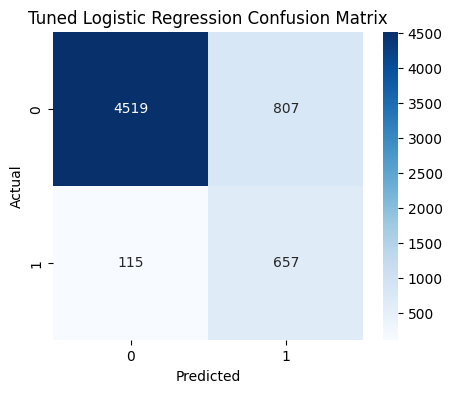

--- Tuned Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      5326
           1       0.54      0.70      0.61       772

    accuracy                           0.89      6098
   macro avg       0.75      0.81      0.77      6098
weighted avg       0.90      0.89      0.89      6098



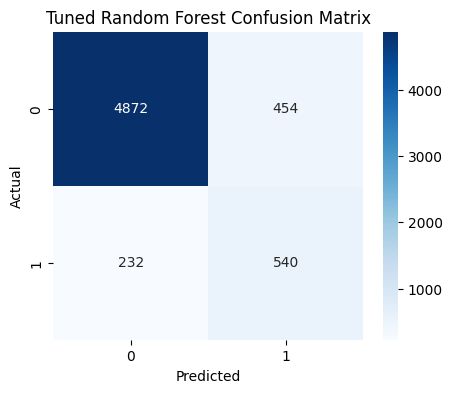

--- Tuned XGBoost Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5326
           1       0.56      0.64      0.60       772

    accuracy                           0.89      6098
   macro avg       0.76      0.78      0.77      6098
weighted avg       0.90      0.89      0.89      6098



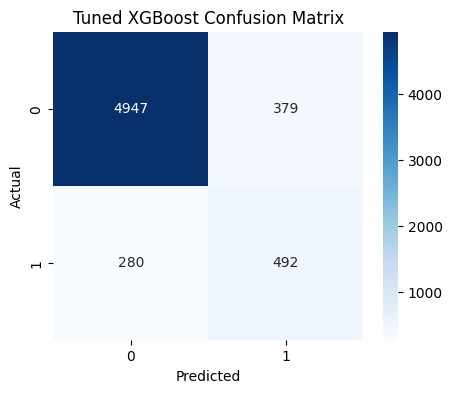

In [60]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(lr_best, X_test_scaled, y_test, 'Tuned Logistic Regression')
evaluate_model(rf_best, X_test_scaled, y_test, 'Tuned Random Forest')
evaluate_model(xgb_best, X_test_scaled, y_test, 'Tuned XGBoost')

#### Findings

Random Forest and XGBoost show balanced improvements in precision and recall for the positive class (subscribers), with Random Forest slightly better in recall and F1.

Logistic Regression has strong recall but lower precision on positive class, which means more false positives.

##### Confusion Matrix

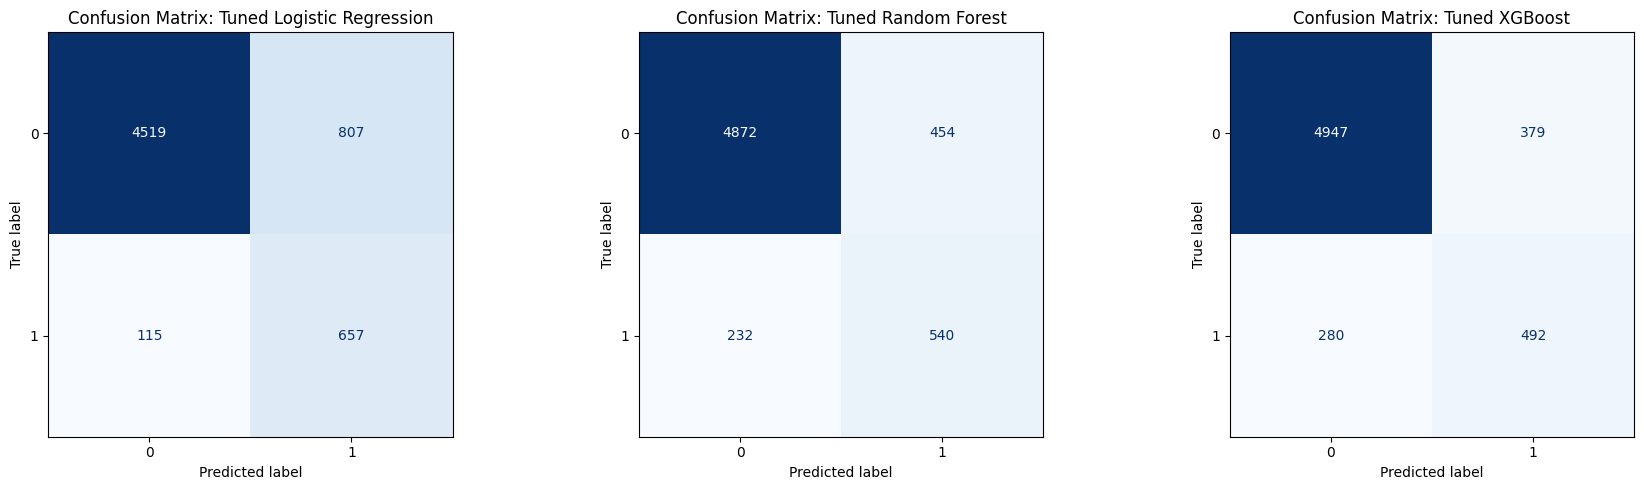

In [64]:
def plot_confusion_matrices(models, X_test, y_test, model_names):
    plt.figure(figsize=(18, 5))
    
    for i, (model, name) in enumerate(zip(models, model_names), 1):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        
        plt.subplot(1, len(models), i)
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
    
    plt.tight_layout()
    plt.show()

# Replace these with your actual tuned models
models = [lr_best, rf_best, xgb_best]
model_names = ['Tuned Logistic Regression', 'Tuned Random Forest', 'Tuned XGBoost']

plot_confusion_matrices(models, X_test_scaled, y_test, model_names)

#### What does this mean?

Logistic Regression has more false positives but fewer false negatives — it predicts more positives but with some risk of false alarms. This is useful if catching more positive cases (subscribers) matters even at some false alarm cost.

Random Forest balances better, reducing false positives but with a higher false negative rate. It misses more positives but reduces false alarms.

XGBoost is the most conservative, with lowest false positives but highest false negatives — it misses more true positives but rarely raises false alarms.

In [67]:
# Define raw confusion matrices (TN, FP, FN, TP) for each model
conf_matrices = {
    'Tuned Logistic Regression': np.array([[4519, 807], [115, 657]]),
    'Tuned Random Forest': np.array([[4872, 454], [232, 540]]),
    'Tuned XGBoost': np.array([[4947, 379], [280, 492]])
}

# Calculate evaluation metrics from confusion matrices
def compute_metrics(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

metrics = {}

for model_name, cm in conf_matrices.items():
    precision, recall, f1 = compute_metrics(cm)
    metrics[model_name] = {
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    }

# Display metrics table
metrics_df = pd.DataFrame(metrics).T
print("\nModel Evaluation Summary:\n")
print(metrics_df)


Model Evaluation Summary:

                           Precision  Recall  F1 Score
Tuned Logistic Regression     0.4488  0.8510    0.5877
Tuned Random Forest           0.5433  0.6995    0.6116
Tuned XGBoost                 0.5649  0.6373    0.5989


#### Save report

In [70]:
import os
os.makedirs('bank-term-deposit-predictor/reports', exist_ok=True)


In [71]:
# Save the confusion matrices to PDF
output_path = 'bank-term-deposit-predictor/reports/confusion_matrices.pdf'
fig.savefig(output_path, format='pdf')
print(f"✅ Confusion matrices saved to: {output_path}")


✅ Confusion matrices saved to: bank-term-deposit-predictor/reports/confusion_matrices.pdf
